In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
import nltk
from sklearn.metrics import confusion_matrix
import spacy
from sklearn.datasets import make_blobs
from sklearn.tree import DecisionTreeClassifier
from ipywidgets import interact
import requests
from bs4 import BeautifulSoup
# Commented out from Win environment
# from scrapy.selector import Selector
import lxml
import pandas as pd
import re
import time
import random
from textblob import TextBlob, Word
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import metrics
from xgboost import XGBClassifier
# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier

# Performance metric
from sklearn.metrics import f1_score

%matplotlib inline

In [2]:
nlp = spacy.load('en_core_web_sm')

In [3]:
job_site = 'https://au.indeed.com'
start_page = '&start='
page_count = ''
counter = 50
store_job = []
next_button_len = 2

In [108]:
url_indeed = 'https://au.indeed.com/jobs?q=%28python+or+sql%29++%28data+or+scientist+or+science+or+analyst+or+research+or+business+or+intelligence+or+analytics+or+statistics+or+Actuarial+or+actuary+or+%22data+engineer%22%29+-developer%2C+-clerk%2C+-software%2C+-network%2C+-security%2C+-programmer&sort=date&radius=50&limit=50'

In [109]:
ua_source_url='https://deviceatlas.com/blog/list-of-user-agent-strings#desktop'

In [110]:
def get_ua_list(source=ua_source_url):
    r = requests.get(source)
    soup = BeautifulSoup(r.content, "html.parser")
    tables = soup.find_all('table')
    return [table.find('td').text for table in tables]

In [111]:
def delay() -> None:
    time.sleep(random.uniform(15, 30))
    return None

In [117]:
random.choice(get_ua_list())

'Mozilla/5.0 (Windows Phone 10.0; Android 6.0.1; Microsoft; RM-1152) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/52.0.2743.116 Mobile Safari/537.36 Edge/15.15254'

In [112]:
def soup_req(url):
    req = requests.get(url, headers={'User-Agent': random.choice(get_ua_list())})
    soup = BeautifulSoup(req.content,features='lxml')
    
    return soup

In [113]:
soup_indeed = soup_req(url_indeed)

In [114]:
link_indeed = soup_indeed.find_all('div', {'class': 'title'})

In [115]:
while next_button_len == 2:
    
    for p_job in link_indeed:
        row = {}
        join_site = [job_site, p_job.find('a')['href']]
        new_url = ''.join(join_site)
        new_soup = soup_req(new_url)

        row['job_title'] = new_soup.find('h3').text if new_soup.find('h3') else 'none'
        row['company_name'] = new_soup.find('div', attrs={'class': 'icl-u-lg-mr--sm icl-u-xs-mr--xs'}).text if new_soup.find('div', attrs={'class': 'icl-u-lg-mr--sm icl-u-xs-mr--xs'}) else 'none'
        row['location'] = new_soup.find_all(attrs={'class': 'jobsearch-JobMetadataHeader-iconLabel'})[0].text if new_soup.find_all(attrs={'class': 'jobsearch-JobMetadataHeader-iconLabel'}) else 'none'

        class_len = len(new_soup.find_all(attrs={'class': 'jobsearch-JobMetadataHeader-iconLabel'}))
        salary = 'none'
        position = 'none'

        for i in range(1,class_len):

            if i == 1:
                row['salary'] = new_soup.find_all(attrs={'class': 'jobsearch-JobMetadataHeader-iconLabel'})[1].text
                if row['salary'][0] != '$':
                    row['position'] = new_soup.find_all(attrs={'class': 'jobsearch-JobMetadataHeader-iconLabel'})[1].text
                    row['salary'] = 'none'
            elif i == 2: 
                row['salary'] = new_soup.find_all(attrs={'class': 'jobsearch-JobMetadataHeader-iconLabel'})[2].text

        row['job_desc'] = new_soup.find('div', attrs={'class': 'jobsearch-JobComponent-description'}).text

        store_job.append(row)
    
    counter += 50
    page_count = counter 
    next_page = ''.join([url_indeed, start_page, str(page_count)])
    delay()
    soup_indeed = soup_req(next_page)
    
    link_indeed = soup_indeed.find_all('div', {'class': 'title'})
    next_button_len = len(soup_indeed.find_all('span', attrs={'class': 'np'}))

### Read file

In [3]:
# store_job = pd.read_csv('./Job_final_output_v3.csv',index_col=0)
store_job1 = pd.read_csv('./validation.csv')

In [4]:
# store_job = pd.read_csv('./Job_final_output.csv',index_col=0)
store_joba = pd.read_csv('./Job_final_output_v2.csv',index_col=0)
store_jobb = pd.read_csv('./Job_final_output_v3.csv',index_col=0)
store_jobc = pd.read_csv('./Job_final_output_v4.csv',index_col=0)
store_jobd = pd.read_csv('./Job_final_output_v5.csv',index_col=0)

In [5]:
# store_job = store_job.append(store_joba).append(store_jobb).append(store_jobc).reindex()
store_job = store_joba.append(store_jobb).append(store_jobc).append(store_jobd).reindex()

In [6]:
store_job.shape

(4059, 6)

In [7]:
store_job.drop_duplicates(subset=['job_title', 'company_name','location',
                           'salary', 'position'],
                   keep='last', inplace=True)

In [8]:
store_job.shape

(2954, 6)

In [9]:
df_job = pd.DataFrame(store_job)
df_job1 = pd.DataFrame(store_job1)

In [10]:
# df_indeed = df_job.copy()
df_job.head()

,job_title,company_name,location,salary,position,job_desc
0,Pricing Manager - Planning and Analytics,American Express,Sydney NSW,none,"Full-time, Part-time","Sydney NSWFull-time, Part-timeThe Global Merch..."
3,Technical Business Analyst,Bendigo & Adelaide Bank,Melbourne VIC,NaN,NaN,Melbourne VICOur Purpose is the same today as ...
6,Marketing Automation Specialist,Jetstar AU,Melbourne VIC,NaN,NaN,"Melbourne VICLocation: Melbourne, Australia\n\..."
7,Martech Analyst,Betfair,Melbourne VIC,"$100,000 a year",NaN,"Melbourne VIC$100,000 a yearCan you believe we..."
9,Senior Technical Business Analyst - PEGA,Paxus,Sydney NSW,none,Contract,Sydney NSWContractLeading Financial Services o...


In [11]:
# df_job.to_csv('Job_final_output.csv')

In [12]:
df_job.isnull().sum()

job_title          0
company_name       0
location           0
job_desc           0
salary          1295
position        1567
dtype: int64

In [13]:
df_job.columns

Index(['job_title', 'company_name', 'location', 'job_desc', 'salary',
       'position'],
      dtype='object')

In [10]:
df_job1.columns = ['job_desc1','company_name', 'company_rating', 'industry', 'job_desc',
       'job_title', 'location', 'salary', 'Bag_of_words']

In [15]:
df_job.dtypes

job_title       object
company_name    object
location        object
job_desc        object
salary          object
position        object
dtype: object

### Data Cleaning

##### Salary Column

In [11]:
df_job = df_job.reset_index(drop=True)

In [12]:
df_job['salary'] = df_job.salary.fillna(value=0)

In [13]:
df_job.at[df_job.loc[df_job.salary == 'none'].index,'salary'] = 0

In [14]:
salary_store = []
idx = 0

for i in df_job.salary:
    a = str(i)
    y = re.findall(r'(?:[\£\$\€]{1}[,\d]+.?\d*[0-9])',a)
    
    if len(y) > 0:
        z = float(re.sub(r'[^\d\.]','',y[0]))
        hdy = re.findall(r'hour|day|year',i)
        if 'hour'in hdy:
            z = z * 7.5 * 20 * 12
        elif 'day' in hdy:
            z = z * 20 * 12
        else:
            z
    else:
        z = 0
#          z = int("".join(map(str, random.sample(set([0, 50000, 100000, 150000, 200000, 250000, 300000]),1))))
    
    salary_store.append(z)
    df_job.salary[idx] = int(z)
    idx += 1

In [15]:
desc_store = []
df_job['desc_salary'] = df_job['salary']
idx = 0

for i in df_job.salary:
    a = str(i)
    y = re.findall(r'(?:[\£\$\€]{1}[,\d]+.?\d*[0-9])',a)
    
    if len(y) > 0:
        z = float(re.sub(r'[^\d\.]','',y[0]))
        if z < 100:
            z = z * 7.5 * 20 * 12
        elif z < 1000:
            z = z * 20 * 12
        else:
            z
    else:
        z = 0
    
    desc_store.append(z)
    df_job['desc_salary'][idx] = int(z)
    idx += 1

In [16]:
idx = 0

for i in df_job.salary:
    if i == 0:
       df_job['salary'][idx] = df_job['desc_salary'][idx]
    
    idx += 1

In [17]:
df_job['salary'] = df_job['salary'].astype('int64') 
df_job1['salary'] = df_job1['salary'].astype('int64') 

In [18]:
np.mean(df_job['salary'])

19663.43568043331

In [19]:
# Remove rows with zero salary
df_job.drop(index=df_job.loc[df_job['salary'] == 0].index,inplace=True)
df_job.drop(columns='desc_salary', axis=1, inplace=True)

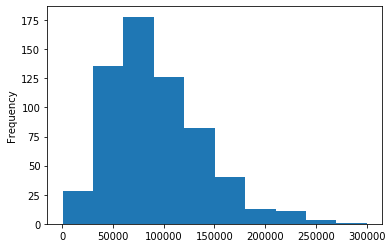

In [20]:
df_job['salary'].plot(kind='hist')

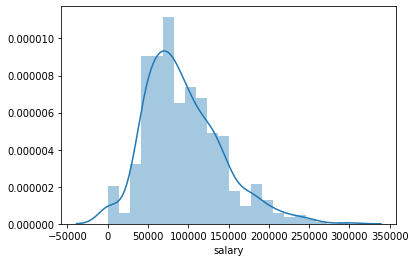

In [21]:
sns.distplot(df_job['salary'])

In [22]:
salary_cat = ["Low", "High"]

df_job['salary'] = pd.qcut(x=df_job['salary'], q=2, labels=salary_cat, precision=6,duplicates='drop')
df_job1['salary'] = pd.qcut(x=df_job1['salary'], q=2, labels=salary_cat)

In [23]:
df_job.groupby(by='salary').size()

salary
Low     313
High    305
dtype: int64

In [20]:
df_job1.groupby(by='salary').size()

salary
Low     2375
High    2373
dtype: int64

In [86]:
df_job.isnull().sum()

job_title          0
company_name       0
location           0
salary             0
position        1999
job_desc           0
dtype: int64

In [294]:
# df_job.dropna(inplace=True)

##### Comapny Column

In [24]:
df_job1['company_name'] = df_job1.company_name.fillna(value='Company not Available')

##### Position Column

In [25]:
df_job['position'] = df_job.position.fillna(value='Position not Available')

In [30]:
df_job.position.unique()

array(['Position not Available', 'Contract', 'Temporary', 'Permanent',
       'Part-time', 'Full-time, Part-time', 'Full-time, Permanent',
       'Full-time, Temporary, Casual', 'Full-time, Part-time, Casual',
       'Full-time, Contract', 'Part-time, Casual',
       'Temporary, Contract, Casual', 'Casual', 'Temporary, Contract',
       'Part-time, Fly-In/Fly-Out, Permanent',
       'Full-time, Part-time, Permanent', 'Part-time, Permanent',
       'Full-time, Part-time, Temporary, Permanent', 'Temporary, Casual',
       'Part-time, Subcontract', 'Internship', 'Part-time, Contract'],
      dtype=object)

##### Description Column

###### Clean HTML

In [26]:
def cleanhtml(raw_html):
  cleanr = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
  cleantext = re.sub(cleanr, '', raw_html)
  return cleantext

###### Clean text

In [27]:
# function for text cleaning 
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
#     text = text.lower() 
    
    return text

In [28]:
df_job['description'] = df_job.job_desc.map(lambda x: cleanhtml(x)) 
df_job['description'] = df_job.description.map(lambda x: clean_text(x))   
df_job.drop(columns='job_desc', inplace=True)

In [29]:
df_job1['description'] = df_job1.job_desc.map(lambda x: clean_text(x))  
df_job1.drop(columns='job_desc', inplace=True)

In [30]:
df_job = df_job.reset_index(drop=True)

In [31]:
df_job.description[3]

'Parramatta NSW a dayContract until end of Financial Year with Possibility of Extension To per day super Work an hour day between am and pm in Government Our client is a government department seeking an experienced person to join its team in Sydneys CBD The Systems Support Analyst provides advanced application support by investigating resolving incidents and problems analysing and designing new applications or modifying existing applications to ensure client business is maintained Key Responsibilities Provide day to day functional and technical support of OneGov application systems maintaining and collating application support documentation Provide timely resolution to application incidents problems and service requests maintain incident action logs and document work arounds and issues as well as managing incidents within SLAs Build and test Siebel application change requests including reference data changes to maintain and improve client business deploy configure and maintain Siebel e

In [32]:
from sklearn.preprocessing import OrdinalEncoder
def prepare_inputs(ds):
    oe = OrdinalEncoder()
    ds = oe.fit_transform(ds)
    return ds

In [100]:
# ## back to dataframe and add our headers
# # df = prepare_inputs(df_job)
# # df_job_new = pd.DataFrame(data=df, columns=df_job.columns)

# oe = OrdinalEncoder()
# ds = oe.fit_transform(df_job)
# df_job_new = pd.DataFrame(data=ds, columns=df_job.columns)

In [101]:
# from imblearn.over_sampling import SMOTE

# # Resample the minority class. You can change the strategy to 'auto' if you are not sure.
# sm = SMOTE(sampling_strategy='minority', random_state=7)

# # Fit the model to generate the data.
# oversampled_trainX, oversampled_trainY = sm.fit_sample(df_job_new.drop('salary', axis=1), df_job_new['salary'])
# # oversampled_trainX, oversampled_trainY = sm.fit_sample(df_job_new.drop('salary'), df_job_new['salary'])
# oversampled_train = pd.concat([pd.DataFrame(oversampled_trainY), pd.DataFrame(oversampled_trainX)], axis=1)
# oversampled_train.columns = ['salary', 'job_title', 'company_name', 'location', 'position', 'description']

In [88]:
# def prepare_output(ds):
#     oe = OrdinalEncoder()
#     oe.fit(ds)
#     new_ds = oe.inverse_transform(ds)
#     return new_ds

In [33]:
# ## back to dataframe and add our headers
# df = oe.inverse_transform(oversampled_train)
# df_job_newer = pd.DataFrame(data=df, columns=oversampled_train.columns)

### Training

In [34]:
# job_string = df_job[['job_title', 'company_name', 'location', 'position', 'description']].stack().groupby(level=0).apply(','.join)
# job_string1 = df_job1[['job_title', 'company_name', 'location', 'industry', 'description']].stack().groupby(level=0).apply(','.join)
job_string = df_job[['job_title', 'company_name', 'location', 'position', 'description']].stack().groupby(level=0).apply(','.join)
job_string1 = df_job1[['job_title', 'company_name', 'location', 'industry', 'description']].stack().groupby(level=0).apply(','.join)

In [35]:
X1 = df_job['job_title']
X2 = df_job['company_name']
X3 = df_job['location']
X4 = df_job['position']
X5 = df_job['description']
X6 = job_string
y = df_job['salary'].values

In [36]:
X1_train, X1_test, y_train, y_test = train_test_split(X1, y, random_state = 42)
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, random_state = 42)
X3_train, X3_test, y_train, y_test = train_test_split(X3, y, random_state = 42)
X4_train, X4_test, y_train, y_test = train_test_split(X4, y, random_state = 42)
# X5_train, X5_test, y_train, y_test = train_test_split(X5, y, random_state = 42)
X6_train, X6_test, y_train, y_test = train_test_split(X6, y, random_state = 42)

##### TfidfVectorizer

In [43]:
def split_into_lemmas(text):
    words = nlp(text)
    return [word.lemma_ for word in words]

In [37]:
tf = TfidfVectorizer(ngram_range=(2,3), stop_words='english', min_df=10, max_features=100000, max_df=0.8) 

In [38]:
X1_train_dtm = tf.fit_transform(X1_train)
X1_test_dtm = tf.transform(X1_test)

X2_train_dtm = tf.fit_transform(X2_train)
X2_test_dtm = tf.transform(X2_test)

X3_train_dtm = tf.fit_transform(X3_train)
X3_test_dtm = tf.transform(X3_test)

X4_train_dtm = tf.fit_transform(X4_train)
X4_test_dtm = tf.transform(X4_test)

# X5_train_dtm = tf.fit_transform(X5_train)
# X5_test_dtm = tf.transform(X5_test)

X6_train_dtm = tf.fit_transform(X6_train)
X6_test_dtm = tf.transform(X6_test)

In [39]:
lr = LogisticRegression(max_iter=5000)

In [40]:
lr.fit(X1_train_dtm, y_train)
y1_pred_class = lr.predict(X1_test_dtm)
print('Job Title   ', metrics.accuracy_score(y_test, y1_pred_class))

lr.fit(X2_train_dtm, y_train)
y2_pred_class = lr.predict(X2_test_dtm)
print('Company Name', metrics.accuracy_score(y_test, y2_pred_class))

lr.fit(X3_train_dtm, y_train)
y3_pred_class = lr.predict(X3_test_dtm)
print('Location    ', metrics.accuracy_score(y_test, y3_pred_class))

lr.fit(X4_train_dtm, y_train)
y4_pred_class = lr.predict(X4_test_dtm)
print('Position    ', metrics.accuracy_score(y_test, y4_pred_class))

# lr.fit(X5_train_dtm, y_train)
# y5_pred_class = lr.predict(X5_test_dtm)
# print('Description ', metrics.accuracy_score(y_test, y5_pred_class))

lr.fit(X6_train_dtm, y_train)
y6_pred_class = lr.predict(X6_test_dtm)
print('All Columns ', metrics.accuracy_score(y_test, y6_pred_class))

Job Title    0.6129032258064516
Company Name 0.5290322580645161
Location     0.6709677419354839
Position     0.5483870967741935
All Columns  0.7290322580645161


In [41]:
conmat = np.array(confusion_matrix(y_test, y6_pred_class, labels=['Low','High']))

confusion = pd.DataFrame(conmat, index=['is_Low','is_High'],
                               columns=['Low', 'High'])
    
confusion

,Low,High
is_Low,58,22
is_High,20,55


In [42]:
print(classification_report(y_test, y6_pred_class, labels=['Low','High']))

              precision    recall  f1-score   support

         Low       0.74      0.72      0.73        80
        High       0.71      0.73      0.72        75

    accuracy                           0.73       155
   macro avg       0.73      0.73      0.73       155
weighted avg       0.73      0.73      0.73       155



In [67]:
#Create an object of the classifier.
bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)

In [44]:
tf = TfidfVectorizer(ngram_range=(2,5), stop_words='english', min_df=20, max_features=100000, max_df=0.8,
                    analyzer=split_into_lemmas)
job_desc_dtm = tf.fit_transform(X5)
desc_df = pd.DataFrame(job_desc_dtm.toarray(),columns=tf.get_feature_names())

In [63]:
# yo = pd.DataFrame(oversampled_train[0])

In [68]:
# yo.columns = ['salary']

In [73]:
# X = oversampled_train.drop(0,axis=1)

In [121]:
pca = PCA(n_components=10)
skl_pca = pca.fit_transform(desc_df)

In [51]:
df_pca = pd.DataFrame(pca.components_.T, index=desc_df.columns)

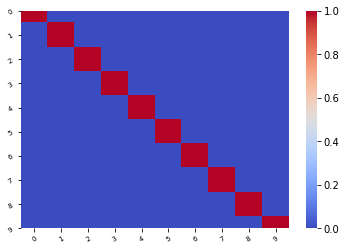

In [94]:
s=sns.heatmap(df_pca.corr(),cmap='coolwarm') 
s.set_yticklabels(s.get_yticklabels(),rotation=30,fontsize=7)
s.set_xticklabels(s.get_xticklabels(),rotation=30,fontsize=7)
plt.show()

In [59]:
X5_train, X5_test, y5_train, y5_test = train_test_split(job_desc_dtm, y, random_state=42, shuffle=True)

In [70]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, yo.values, test_size=0.33, random_state=7)
# fit model no training data
model = XGBClassifier()
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, eval_metric="error", eval_set=eval_set, verbose=True)

NameError: name 'X' is not defined

In [ ]:
# train_x, test_x, train_y, test_y = train_test_split(
#         train_cat, y, test_size=0.25)
# train_set = xgb.DMatrix(train_x, label=train_y)
# test_set = xgb.DMatrix(test_x, label=test_y)
# bst = xgb.train(
#     config, train_set, evals=[(test_set, "eval")])
# pred_labels = bst.predict(test_set)

In [72]:
# fit model no training data
model = XGBClassifier()
eval_set = [(X5_test, y5_test)]
model.fit(X5_train, y5_train, eval_metric="error", eval_set=eval_set, verbose=True)


# make predictions for test data
y_pred = model.predict(X5_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y5_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

# plot log loss
fig, ax = pyplot.subplots(figsize=(12,12))
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()

pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()


# plot classification error
fig, ax = pyplot.subplots(figsize=(12,12))
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()

pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

[0]	validation_0-error:0.341935
[1]	validation_0-error:0.296774
[2]	validation_0-error:0.296774
[3]	validation_0-error:0.283871
[4]	validation_0-error:0.290323
[5]	validation_0-error:0.270968
[6]	validation_0-error:0.23871
[7]	validation_0-error:0.290323
[8]	validation_0-error:0.251613
[9]	validation_0-error:0.264516
[10]	validation_0-error:0.264516
[11]	validation_0-error:0.277419
[12]	validation_0-error:0.270968
[13]	validation_0-error:0.258065
[14]	validation_0-error:0.232258
[15]	validation_0-error:0.258065
[16]	validation_0-error:0.245161
[17]	validation_0-error:0.225806
[18]	validation_0-error:0.245161
[19]	validation_0-error:0.225806
[20]	validation_0-error:0.232258
[21]	validation_0-error:0.225806
[22]	validation_0-error:0.232258
[23]	validation_0-error:0.23871
[24]	validation_0-error:0.23871
[25]	validation_0-error:0.245161
[26]	validation_0-error:0.245161
[27]	validation_0-error:0.245161
[28]	validation_0-error:0.23871
[29]	validation_0-error:0.251613
[30]	validation_0-error:

TypeError: type str doesn't define __round__ method

In [120]:

# fit model no training data
model = XGBClassifier(booster='dart')
eval_set = [(X5_test, y5_test)]
xgbc.fit(X5_train, y5_train, eval_metric="error", eval_set=eval_set, verbose=True)


# make predictions for test data
y_pred = model.predict(X5_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y5_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

# plot log loss
fig, ax = pyplot.subplots(figsize=(12,12))
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()

pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()


# plot classification error
fig, ax = pyplot.subplots(figsize=(12,12))
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()

pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

MemoryError: Unable to allocate 1.01 GiB for an array with shape (3546, 38213) and data type float64

In [60]:
xgbc = XGBClassifier()
xgbc.fit(X5_train, y5_train)
y5_pred_class = xgbc.predict(X5_test)
print(metrics.accuracy_score(y5_test, y5_pred_class))

0.7612903225806451


In [61]:
desc_conmat = np.array(confusion_matrix(y5_test, y5_pred_class, labels=['Low','High']))

desc_confusion = pd.DataFrame(desc_conmat, index=['is_Low','is_High'],
                               columns=['Low', 'High'])
    
desc_confusion

,Low,High
is_Low,60,20
is_High,17,58


In [62]:
print(classification_report(y5_test, y5_pred_class, labels=['Low','High']))

              precision    recall  f1-score   support

         Low       0.78      0.75      0.76        80
        High       0.74      0.77      0.76        75

    accuracy                           0.76       155
   macro avg       0.76      0.76      0.76       155
weighted avg       0.76      0.76      0.76       155



In [63]:
feat_impt = pd.DataFrame({'feature':desc_df.columns, 'importance':xgbc.feature_importances_})
  
feat_impt.sort_values('importance', ascending=False, inplace=True)
feat_impt.head(10)

,feature,importance
654,hour,0.040315
51,Data,0.026235
1150,time,0.023597
193,Type,0.022898
381,competitive,0.020091
1127,technology,0.018704
159,SQL,0.018171
1017,return,0.017378
535,entry,0.016841
1243,would,0.015533


In [197]:
coeff = pd.DataFrame({'feature':desc_df.columns, 'coefficient': xgbc.coef_[0]**2})
    
coeff.sort_values('coefficient', ascending=False, inplace=True)
coeff.head(20)

AttributeError: Coefficients are not defined for Booster type gbtree

In [64]:
dt = DecisionTreeClassifier(max_depth=20)
dt.fit(X5_train, y5_train)
dty_pred_class = dt.predict(X5_test)
print(metrics.accuracy_score(y5_test, dty_pred_class))

0.6516129032258065


In [65]:
desc_conmat = np.array(confusion_matrix(y5_test, dty_pred_class, labels=['Low','High']))

desc_confusion = pd.DataFrame(desc_conmat, index=['is_Low','is_High'],
                               columns=['Low', 'High'])
    
desc_confusion

,Low,High
is_Low,53,27
is_High,27,48


In [66]:
svc = SVC(C=1, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='linear', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False)
svc.fit(X5_train, y5_train)
y5_pred_class = svc.predict(X5_test)
print('Description ', metrics.accuracy_score(y5_test, y5_pred_class))

Description  0.7483870967741936


In [109]:
bbc.fit(X5_train, y5_train)
y5_pred_class = bbc.predict(X5_test)
print('Description ', metrics.accuracy_score(y5_test, y5_pred_class))

Description  0.7


In [67]:
desc_conmat = np.array(confusion_matrix(y5_test, y5_pred_class, labels=['Low','High']))

desc_confusion = pd.DataFrame(desc_conmat, index=['is_Low','is_High'],
                               columns=['Low', 'High'])
    
desc_confusion

,Low,High
is_Low,62,18
is_High,21,54


In [68]:
print(classification_report(y5_test, y5_pred_class, labels=['Low','High']))

              precision    recall  f1-score   support

         Low       0.75      0.78      0.76        80
        High       0.75      0.72      0.73        75

    accuracy                           0.75       155
   macro avg       0.75      0.75      0.75       155
weighted avg       0.75      0.75      0.75       155



In [69]:
feat_impt = pd.DataFrame({'feature':desc_df.columns, 'importance':dt.feature_importances_})
  
feat_impt.sort_values('importance', ascending=False, inplace=True)
feat_impt.head(10)

,feature,importance
654,hour,0.161326
1017,return,0.065209
1127,technology,0.058183
381,competitive,0.036976
23,BI,0.034203
889,pipeline,0.033728
475,difference,0.031214
997,report,0.028211
535,entry,0.027484
327,button,0.026280


In [57]:
coeff = pd.DataFrame({'feature':desc_df.columns, 'coefficient': svc.coef_[0]**2})
    
coeff.sort_values('coefficient', ascending=False, inplace=True)
coeff.head(10)

,feature,coefficient
1150,time,2.319928
442,data,2.241432
725,lead,2.225648
535,entry,2.069165
1031,science,1.778323
654,hour,1.745695
694,integration,1.702875
969,re,1.496788
628,graduate,1.422887
1094,strong,1.372177


##### TfidfVectorizer Validation

In [233]:
X1 = job_string1
y1 = df_job1['salary'].values

In [234]:
tf = TfidfVectorizer(ngram_range=(1,5), stop_words='english', min_df=10, max_features=100000, max_df=0.8,
                       analyzer=split_into_lemmas)
X_dtm = tf.fit_transform(X)
X1_dtm = tf.transform(X1)

In [235]:
lr = LogisticRegression(max_iter=5000)
lr.fit(X_dtm, y)
y_pred_class1 = lr.predict(X1_dtm)
print(metrics.accuracy_score(y1, y_pred_class1)*100)

69.65037910699242


In [236]:
lr = LogisticRegression(max_iter=5000)
lr.fit(X_dtm, y)
yhat_lr = lr.predict(X1_dtm)

conmat = np.array(confusion_matrix(y1, yhat_lr, labels=['Low','High']))

confusion = pd.DataFrame(conmat, index=['is_Low','is_High'],
                               columns=['Low', 'High'])
    
confusion

,Low,High
is_Low,2096,279
is_High,1162,1211


In [245]:
print(classification_report(y1, yhat_lr, labels=['Low','High']))

              precision    recall  f1-score   support

         Low       0.64      0.88      0.74      2375
        High       0.81      0.51      0.63      2373

    accuracy                           0.70      4748
   macro avg       0.73      0.70      0.69      4748
weighted avg       0.73      0.70      0.69      4748



##### Decision Tree

In [135]:
dt = DecisionTreeClassifier(max_depth=20)

In [101]:
dt.fit(X1_train_dtm, y_train)
y1_pred_class = dt.predict(X1_test_dtm)
print('Job Title   ', metrics.accuracy_score(y_test, y1_pred_class))

dt.fit(X2_train_dtm, y_train)
y2_pred_class = dt.predict(X2_test_dtm)
print('Company Name', metrics.accuracy_score(y_test, y2_pred_class))

dt.fit(X3_train_dtm, y_train)
y3_pred_class = dt.predict(X3_test_dtm)
print('Location    ', metrics.accuracy_score(y_test, y3_pred_class))

dt.fit(X4_train_dtm, y_train)
y4_pred_class = dt.predict(X4_test_dtm)
print('Position    ', metrics.accuracy_score(y_test, y4_pred_class))

dt.fit(X5_train_dtm, y_train)
y5_pred_class = dt.predict(X5_test_dtm)
print('Description ', metrics.accuracy_score(y_test, y5_pred_class))

dt.fit(X6_train_dtm, y_train)
y6_pred_class = dt.predict(X6_test_dtm)
print('All Columns ', metrics.accuracy_score(y_test, y6_pred_class))

Job Title    0.5445544554455446
Company Name 0.6039603960396039
Location     0.693069306930693
Position     0.5544554455445545
Description  0.7128712871287128
All Columns  0.7128712871287128


In [95]:
fi = pd.DataFrame({'feature':X5, 'importance':dt.feature_importances_})

# print 'median salary for whole Australia = ', np.mean(df2.salary_byhour)
    
fi.sort_values('importance', ascending=False, inplace=True)
fi.head(10)

ValueError: array length 1068 does not match index length 401

##### Decision Tree Validation

In [117]:
dt = DecisionTreeClassifier(max_depth=20)
dt.fit(X_dtm, y)
dty_pred_class = dt.predict(X1_dtm)
print(metrics.accuracy_score(y1, dty_pred_class)*100)

NameError: name 'X_dtm' is not defined

#### Baseline

In [178]:
Se_test = pd.Series(y5_test)

In [179]:
max(Se_test.value_counts(normalize=True)*100)

50.588235294117645

### Section 2

In [212]:
description = nltk.FreqDist(df_job['description']) 

# create dataframe
description_df = pd.DataFrame({'Title': list(description.keys()), 
                              'Count': list(description.values())})

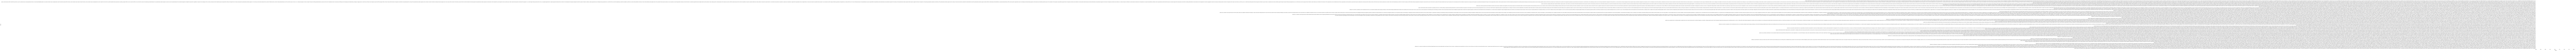

In [213]:
g = description_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Title") 
ax.set(ylabel = 'Count') 
plt.show()

In [214]:
company_name = nltk.FreqDist(df_job['company_name']) 

# create dataframe
company_name_df = pd.DataFrame({'Title': list(company_name.keys()), 
                              'Count': list(company_name.values())})

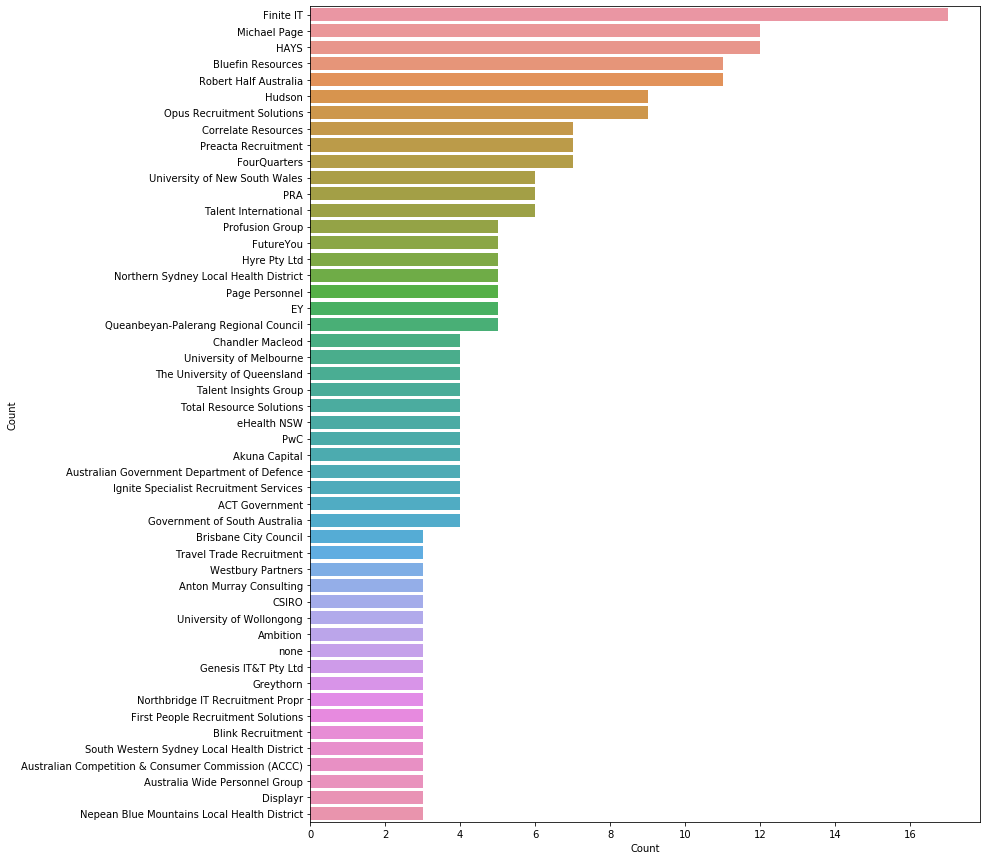

In [215]:
g = company_name_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Title") 
ax.set(ylabel = 'Count') 
plt.show()

In [216]:
job_title = nltk.FreqDist(df_job['job_title']) 

# create dataframe
job_title_df = pd.DataFrame({'Title': list(job_title.keys()), 
                              'Count': list(job_title.values())})

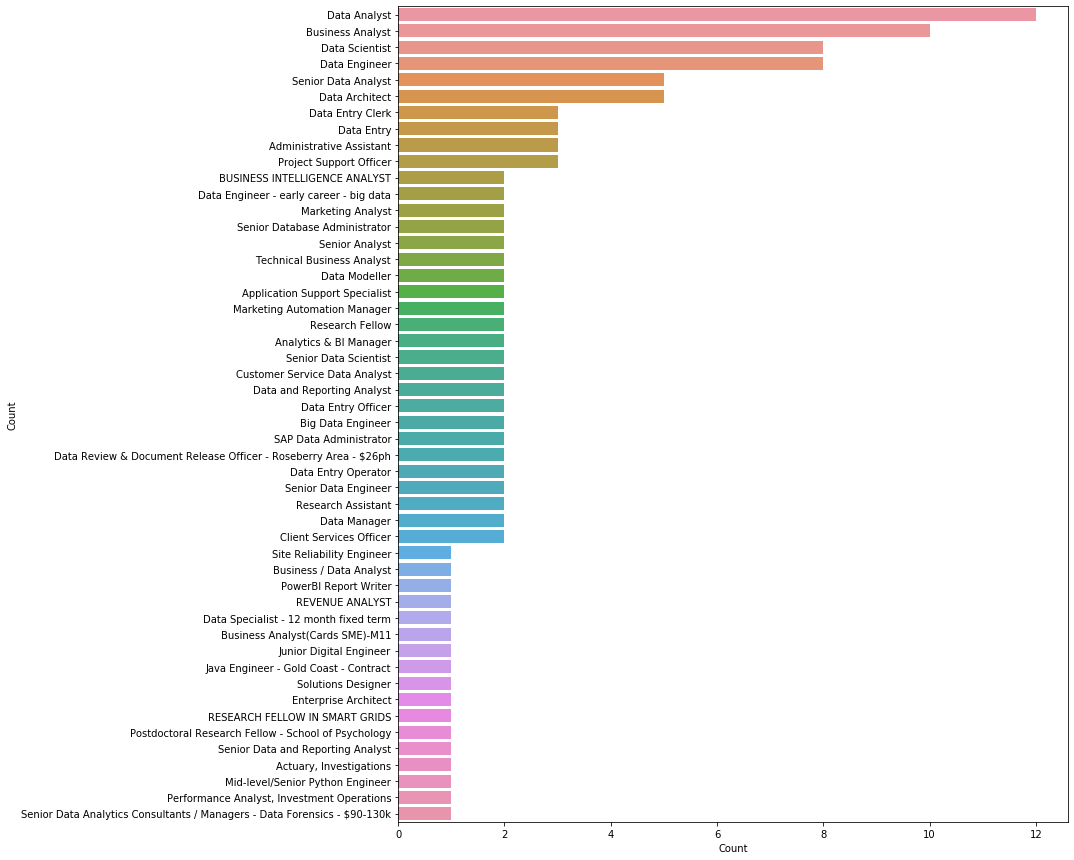

In [217]:
g = job_title_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Title") 
ax.set(ylabel = 'Count') 
plt.show()

In [123]:
job_string3 = df_job[['company_name', 'location', 'position', 'salary', 'description']].stack().groupby(level=0).apply(','.join)

In [96]:
dummies = pd.get_dummies(df_job.job_title)

In [97]:
df_da = dummies['Data Analyst']
df_ds = dummies['Data Scientist']
df_de = dummies['Data Engineer']
df_data = pd.DataFrame([df_da, df_de, df_ds]).T
new_title = df_data.sum(axis = 1)
df_new_title = pd.DataFrame(new_title)
df_job['new_title'] = df_new_title

In [98]:
X = df_job['description']
y = df_job['new_title']
yc = df_job['company_name']
yl = df_job['location']
yp = df_job['position']
ys = df_job['salary']
yt = df_job['job_title']

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
Xc_train, Xc_test, yc_train, yc_test = train_test_split(X, yc, random_state = 42)
Xl_train, Xl_test, yl_train, yl_test = train_test_split(X, yl, random_state = 42)
Xp_train, Xp_test, yp_train, yp_test = train_test_split(X, yp, random_state = 42)
# Xs_train, Xs_test, ys_train, ys_test = train_test_split(X, ys, random_state = 42)
Xt_train, Xt_test, yt_train, yt_test = train_test_split(X, yt, random_state = 42)

In [317]:
tf = TfidfVectorizer(ngram_range=(2,4), stop_words='english', min_df=10, max_features=10000, max_df=0.5) 

In [318]:
Xc_train_dtm = tf.fit_transform(Xc_train)
Xc_test_dtm = tf.transform(Xc_test)

Xl_train_dtm = tf.fit_transform(Xl_train)
Xl_test_dtm = tf.transform(Xl_test)

Xp_train_dtm = tf.fit_transform(Xp_train)
Xp_test_dtm = tf.transform(Xp_test)

# Xs_train_dtm = tf.fit_transform(Xs_train)
# Xs_test_dtm = tf.transform(Xs_test)

Xt_train_dtm = tf.fit_transform(Xt_train)
Xt_test_dtm = tf.transform(Xt_test)


In [319]:
xgbc = XGBClassifier(objective='binary')

In [321]:
xgbc.fit(Xc_train_dtm, yc_train)
yc_pred_class = xgbc.predict(Xc_test_dtm)
print(metrics.accuracy_score(yc_test, yc_pred_class))

xgbc.fit(Xl_train_dtm, yl_train)
yl_pred_class = xgbc.predict(Xl_test_dtm)
print(metrics.accuracy_score(yl_test, yl_pred_class))

xgbc.fit(Xp_train_dtm, yp_train)
yp_pred_class = xgbc.predict(Xp_test_dtm)
print(metrics.accuracy_score(yp_test, yp_pred_class))

# xgbc.fit(Xs_train_dtm, ys_train)
# ys_pred_class = xgbc.predict(Xs_test_dtm)
# print(metrics.accuracy_score(ys_test, ys_pred_class))

xgbc.fit(Xt_train_dtm, yt_train)
yt_pred_class = xgbc.predict(Xt_test_dtm)
print(metrics.accuracy_score(yt_test, yt_pred_class))

0.19858156028368795
0.5177304964539007
0.7943262411347518
0.07801418439716312


In [340]:
f1_company = f1_score(yc_test, yc_pred_class, average="micro")
f1_location = f1_score(yl_test, yl_pred_class, average="micro")
f1_position = f1_score(yp_test, yp_pred_class, average="micro")
# f1s_score(ys_test, ys_pred_class, average="micro")
f1_title = f1_score(yt_test, yt_pred_class, average="micro")

print('Company', f1_company)
print('Location', f1_location)
print('Position', f1_position)
print('Title', f1_title)

Company 0.19858156028368792
Location 0.5177304964539007
Position 0.7943262411347517
Title 0.07801418439716312


In [109]:
cv = CountVectorizer(ngram_range=(2,3), stop_words='english', min_df=10, max_features=100000, max_df=0.5)
# X_train_dtm = cv.fit_transform(X_train)
# X_test_dtm = cv.transform(X_test)
job_desc_dtm = cv.fit_transform(X)
# X_test_dtm = cv.transform(X_test)
desc_df = pd.DataFrame(job_desc_dtm.toarray(),columns=cv.get_feature_names())

In [110]:
X_train, X_test, y_train, y_test = train_test_split(desc_df, y, test_size=0.3, random_state=42, shuffle=True)

In [114]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_class = lr.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred_class))

0.9176470588235294


In [111]:
bbc.fit(X_train, y_train)
y_pred_class = bbc.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred_class))

0.8588235294117647


In [112]:
desc_conmat = np.array(confusion_matrix(y_test, y_pred_class, labels=[0,1]))

desc_confusion = pd.DataFrame(desc_conmat, index=['is_zero','is_one'],
                               columns=['Zero', 'One'])
    
desc_confusion

,Zero,One
is_zero,139,18
is_one,6,7


In [113]:
print(classification_report(y_test, y_pred_class, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.96      0.89      0.92       157
           1       0.28      0.54      0.37        13

    accuracy                           0.86       170
   macro avg       0.62      0.71      0.64       170
weighted avg       0.91      0.86      0.88       170



In [115]:
coeff = pd.DataFrame({'feature':desc_df.columns, 'coefficient': lr.coef_[0]**2})
    
coeff.sort_values('coefficient', ascending=False, inplace=True)
coeff.head(20)

,feature,coefficient
425,hourly rate,0.687301
252,data scientist,0.453368
218,data analysis,0.389528
229,data engineer,0.339110
512,machine learning,0.302212
805,statistical analysis,0.255706
176,communication skills,0.253876
125,canberra actcontract,0.212867
741,role working,0.206053
58,apply contact,0.191151


##### Baseline

In [81]:
Se_test = pd.Series(y3_test)
max(Se_test.value_counts(normalize=True)*100)

2.9702970297029703

In [63]:
import pyLDAvis
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.decomposition import LatentDirichletAllocation

In [64]:
def split_into_blob(text):
    text = str(text).lower()
    words = TextBlob(text).words
    return [word.lemmatize() for word in words]

In [65]:
tf_vectorizer = TfidfVectorizer(strip_accents='unicode', stop_words='english', lowercase=True,  
                                token_pattern=r'\b[a-zA-Z]{3,}\b|\n', min_df=10, max_df=0.8, ngram_range=(2, 5))

In [67]:
dtm_tf = tf_vectorizer.fit_transform(X5)

In [101]:
lda_tf = LatentDirichletAllocation(n_components=20, random_state=0)
lda_tf.fit(dtm_tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=20, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [102]:
lda_vis_tf = pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer)

/home/glitch/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [103]:
pyLDAvis.display(lda_vis_tf)